# Spotify Song Genre Classification Lab Work


## 1. Import Libraries

In [3]:
!pip install category_encoders
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00


In [4]:
# libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Preprocessing and Feature Engineering
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from category_encoders import TargetEncoder # For encoding high-cardinality features like 'track_artist'
from scipy.stats import uniform, randint # For RandomizedSearch parameter distributions

# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Metrics for evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer, log_loss, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Neural Network (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set a consistent plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print('All libraries imported successfully!')

All libraries imported successfully!


## 2. Data Loading and Initial Inspection

In [15]:
# Load the dataset from the CSV file.
try:
    df = pd.read_csv('/content/spotify_songs.csv')
except FileNotFoundError:
    print("Error: 'spotify_songs.csv' not found. Please place it in the correct directory.")
    df = pd.DataFrame() # Create an empty DataFrame to prevent subsequent errors


if not df.empty:
    print(f'Dataset Shape: {df.shape}')
    print(f'Number of Songs: {df.shape[0]:,}')
    print(f'Number of Features: {df.shape[1]}\n')

    print("First 5 Rows:")
    display(df.head())

    print("\nDataset Info (columns, data types, non-null counts):")
    df.info()

Dataset Shape: (32833, 23)
Number of Songs: 32,833
Number of Features: 23

First 5 Rows:


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052



Dataset Info (columns, data types, non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key    

## 3. Missing Values and Target Variable Analysis

In [16]:
if not df.empty:
    #  1. Missing Values Analysis
    print(" Missing Values Analysis ")
    missing_values = df.isnull().sum()
    missing_df = missing_values[missing_values > 0].to_frame(name='Missing_Count')
    missing_df['Missing_Percentage'] = (missing_df['Missing_Count'] / len(df)) * 100

    if not missing_df.empty:
        print("Found missing values:")
        display(missing_df.sort_values('Missing_Count', ascending=False))

        # Fill NaNs in object columns with 'unknown', as they are likely meaningful categories.
        for col_name in missing_df.index:
            if df[col_name].dtype == 'object':
                df[col_name] = df[col_name].fillna('unknown')
                print(f"✓ Filled NaNs in '{col_name}' with 'unknown'.")
    else:
        print(' No missing values found!')

    #  2. Target Variable (Genre) Analysis
    print('Genre Distribution Analysis ')
    genre_counts = df['playlist_genre'].value_counts()
    print(f'Number of unique genres: {df["playlist_genre"].nunique()}\n')
    print(genre_counts)

 Missing Values Analysis 
Found missing values:


,Missing_Count,Missing_Percentage
track_name,5,0.015229
track_artist,5,0.015229
track_album_name,5,0.015229


✓ Filled NaNs in 'track_name' with 'unknown'.
✓ Filled NaNs in 'track_artist' with 'unknown'.
✓ Filled NaNs in 'track_album_name' with 'unknown'.
Genre Distribution Analysis 
Number of unique genres: 6

playlist_genre
edm      6043
rap      5746
pop      5507
r&b      5431
latin    5155
rock     4951
Name: count, dtype: int64


## 4. Visualizing the Genre Distribution


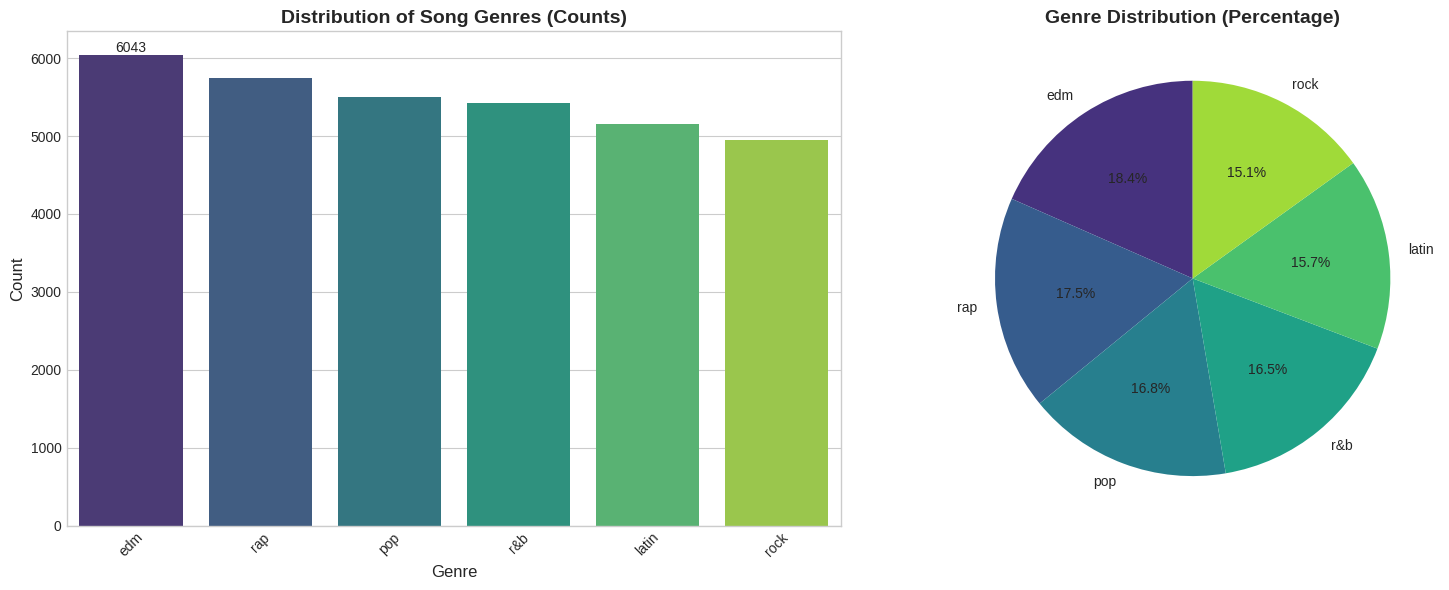

Balance Ratio (max/min): 1.22
✓ Classes are well balanced. No special sampling techniques are required.


In [ ]:
if not df.empty:
    # Create a figure with two subplots: a bar chart and a pie chart.
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    #  Plot 1: Bar Chart for absolute counts
    sns.countplot(data=df, x='playlist_genre', order=genre_counts.index, ax=axes[0], palette='viridis')
    axes[0].set_title('Distribution of Song Genres (Counts)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Genre', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].bar_label(axes[0].containers[0]) # Add labels to bars

    # Plot 2: Pie Chart for percentages
    axes[1].pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette('viridis', len(genre_counts)))
    axes[1].set_title('Genre Distribution (Percentage)', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Check the balance ratio to confirm if resampling is needed.
    balance_ratio = genre_counts.max() / genre_counts.min()
    print(f'Balance Ratio (max/min): {balance_ratio:.2f}')
    if balance_ratio < 2:
        print('✓ Classes are well balanced. No special sampling techniques are required.')
    else:
        print('⚠ Classes may be imbalanced, consider resampling if model performance is poor for minority classes.')

In [17]:
plot_data = df.copy() # Use the appropriate dataframe that has the original string genre/subgenre names

# Group by Genre and Subgenre to calculate count and mean popularity
sunburst_data = plot_data.groupby(['playlist_genre', 'playlist_subgenre'])['track_popularity'].agg(['count', 'mean']).reset_index()

# Rename columns for clarity in the plot
sunburst_data.rename(columns={'mean': 'Average Popularity', 'count': 'Number of Songs'}, inplace=True)

# Optional: Capitalize for better display
sunburst_data['playlist_genre'] = sunburst_data['playlist_genre'].str.capitalize()
sunburst_data['playlist_subgenre'] = sunburst_data['playlist_subgenre'].str.capitalize()

print("Sunburst data prepared:")
display(sunburst_data.head())



Sunburst data prepared:


,playlist_genre,playlist_subgenre,Number of Songs,Average Popularity
0,Edm,Big room,1206,32.282753
1,Edm,Electro house,1511,35.510258
2,Edm,Pop edm,1517,45.686223
3,Edm,Progressive electro house,1809,26.867883
4,Latin,Latin hip hop,1656,43.451087


In [ ]:
import plotly.express as px

if 'sunburst_data' in locals() and not sunburst_data.empty:
    fig = px.sunburst(
        sunburst_data,
        path=['playlist_genre', 'playlist_subgenre'], # Hierarchy: Genre -> Subgenre
        values='Number of Songs',                 # Size of segments based on song count
        color='Average Popularity',                # Color segments based on average popularity
        color_continuous_scale=px.colors.sequential.Viridis, # Use a nice color scale (e.g., Viridis, Plasma, Cividis)
        
    )

    # Update hover information for more detail
    fig.update_traces(
        hovertemplate=(
            "<b>%{label}</b><br>" +
            "Genre: %{parent}<br>" +
            "Number of Songs: %{value}<br>" +
            "Avg Popularity: %{color:.2f}" +
            "<extra></extra>" # Removes the default trace info
        ),
         # Add text labels inside segments (optional, can be cluttered)
        # textinfo='label+percent entry'
    )

    # Update layout for a clearer title and slightly larger margins
    fig.update_layout(
        title={
            'text': "<b>Spotify Genre/Subgenre Distribution</b><br>Size = Song Count | Color = Avg. Popularity",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font_size': 18
        },
        margin=dict(t=100, l=25, r=25, b=25)
    )

    fig.show()
else:
    print("Sunburst data not available or empty. ")

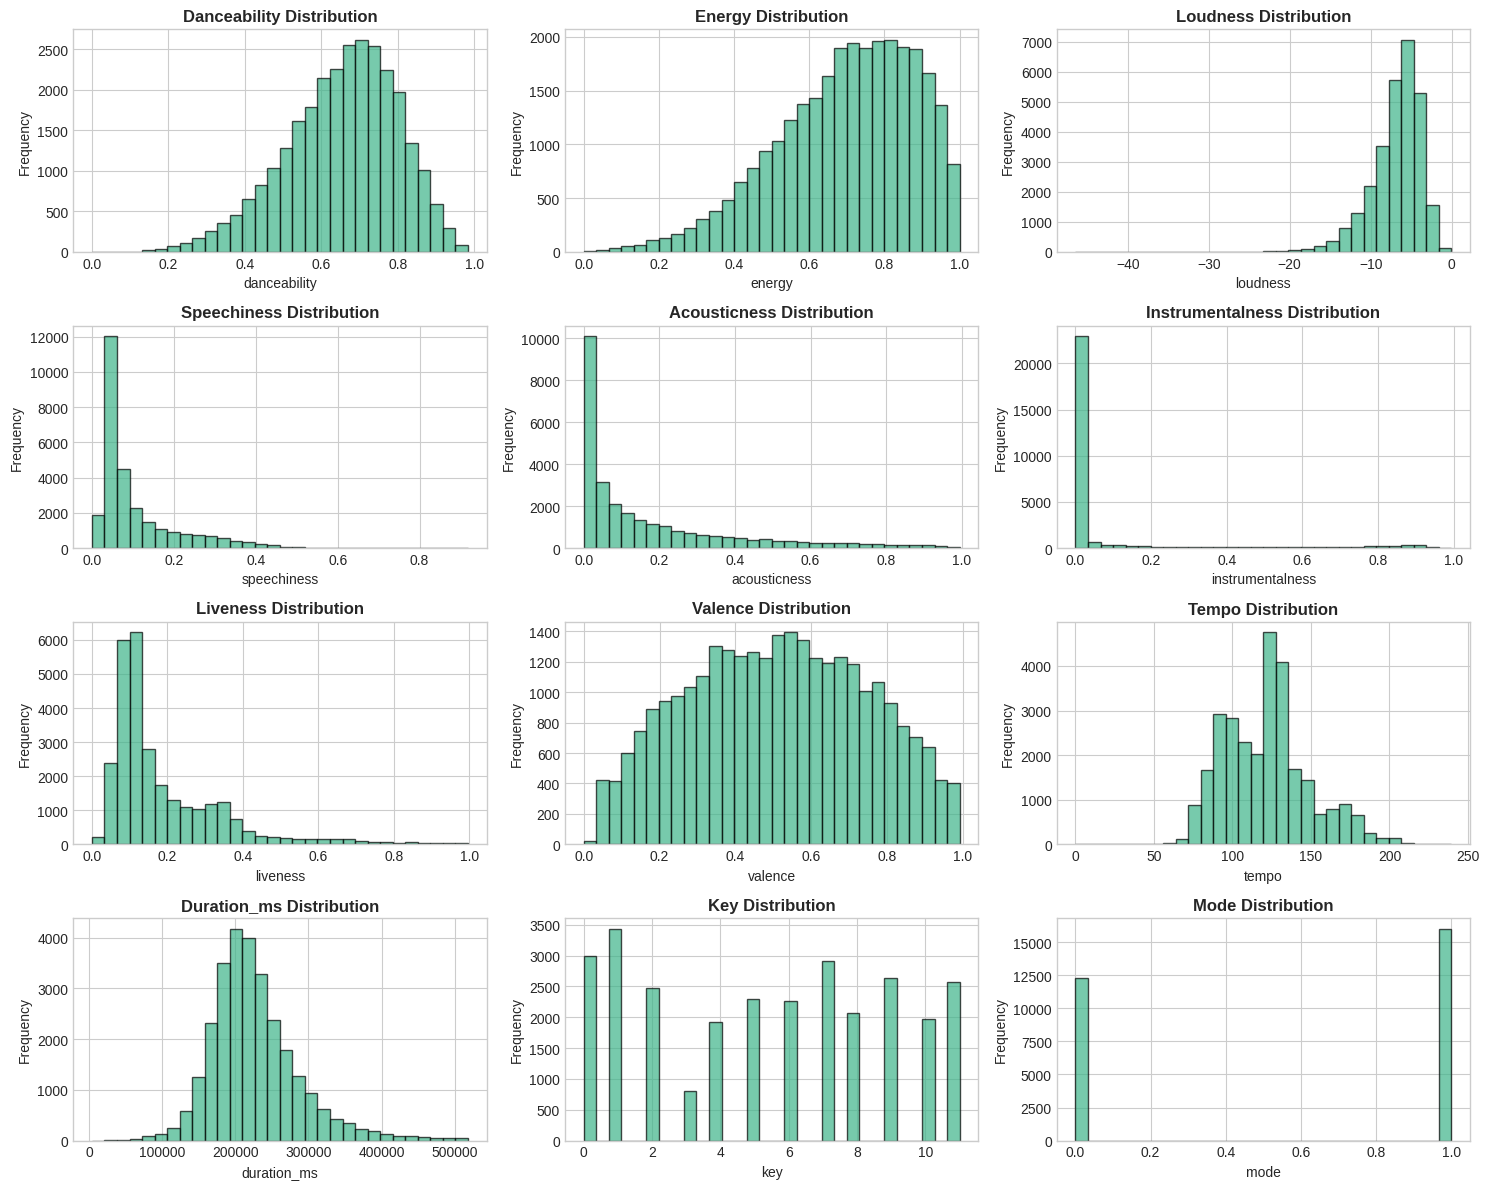

In [21]:
audio_features = ['danceability', 'energy', 'loudness', 'speechiness',
                  'acousticness', 'instrumentalness', 'liveness', 'valence',
                  'tempo', 'duration_ms', 'key', 'mode']
audio_features = [f for f in audio_features if f in df_cleaned.columns]

fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(audio_features):
    axes[idx].hist(df_cleaned[feature], bins=30, edgecolor='black', alpha=0.7, color='#3EB489')
    axes[idx].set_title(f'{feature.capitalize()} Distribution', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

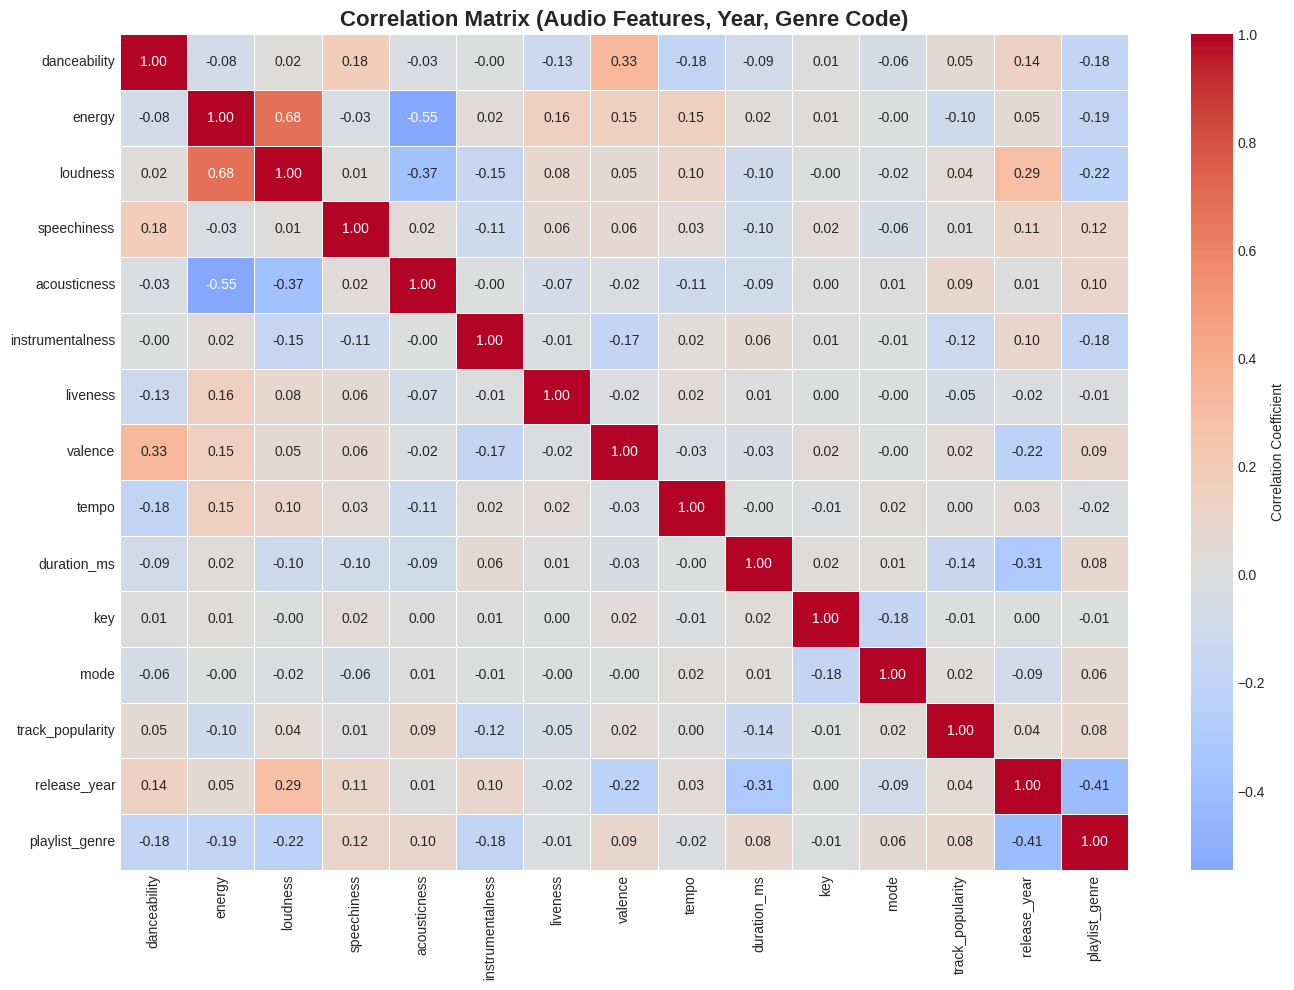


Highly Correlated Pairs (|r| > 0.5):
energy <-> loudness: 0.682
energy <-> acousticness: -0.546


In [31]:
if not df.empty:
    # Select only the original numeric audio features + year for correlation heatmap
    audio_features_plot = ['danceability', 'energy', 'loudness', 'speechiness',
                           'acousticness', 'instrumentalness', 'liveness', 'valence',
                           'tempo', 'duration_ms', 'key', 'mode', 'track_popularity', 'release_year']
    cols_for_corr = audio_features_plot + ['playlist_genre'] # include encoded target
    numeric_df_corr = df_cleaned[cols_for_corr].copy()
    correlation_matrix = numeric_df_corr.corr()

    plt.figure(figsize=(14, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f',
                linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Correlation Matrix (Audio Features, Year, Genre Code)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # High correlations (excluding self-correlation)
    print('\nHighly Correlated Pairs (|r| > 0.5):')
    high_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.5:
                print(f'{correlation_matrix.columns[i]} <-> {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]:.3f}')

Outlier detection via Violin Plot + stripplot

--- Visualizing Outliers using Violin Plots ---


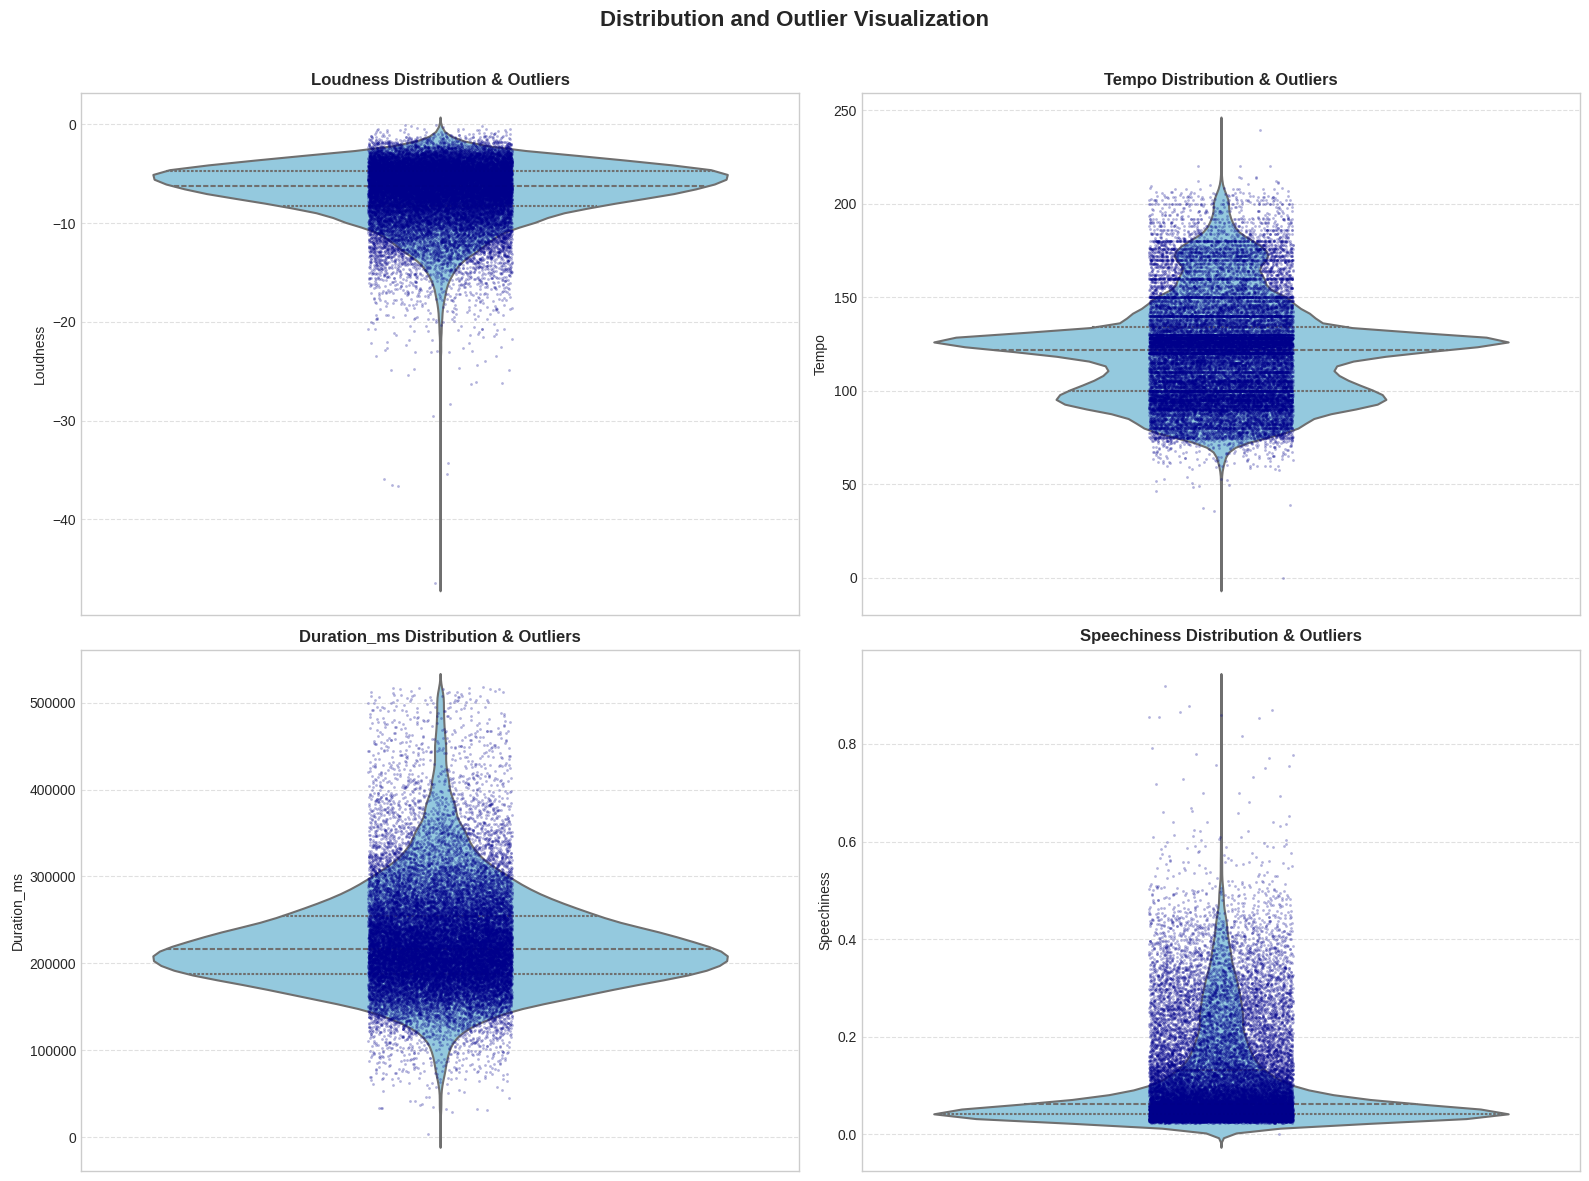


--- Outlier Counts using IQR ---
loudness: 835 outliers (2.95%)
tempo: 494 outliers (1.74%)
duration_ms: 1197 outliers (4.22%)
speechiness: 2725 outliers (9.61%)


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


if 'df_cleaned' in locals() and not df_cleaned.empty:

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    outlier_features = ['loudness', 'tempo', 'duration_ms', 'speechiness']
    outlier_features = [f for f in outlier_features if f in df_cleaned.columns]

    print(" Visualizing Outliers using Violin Plots ")

    for idx, feature in enumerate(outlier_features):
        if idx < len(axes):
            # 1. Violin Plot: Shows the distribution shape, median, and interquartile range.
            sns.violinplot(
                y=df_cleaned[feature], # Use y-axis for vertical orientation
                ax=axes[idx],
                color="skyblue",      # Set a consistent color
                inner="quartile",     # Show Q1, median, Q3 lines inside
                linewidth=1.5
            )

            # 2. Stripplot  Shows individual points, useful for outliers.
            #    Use jitter and alpha for better visibility, especially with many points.
            sns.stripplot(
                y=df_cleaned[feature],
                ax=axes[idx],
                color="darkblue",      # A darker color for points
                size=2,                # Smaller points
                alpha=0.3,             # Transparency for dense areas
                jitter=True            # Spread points horizontally slightly
            )

            axes[idx].set_title(f'{feature.capitalize()} Distribution & Outliers', fontweight='bold', fontsize=12)
            axes[idx].set_ylabel(feature.capitalize(), fontsize=10) # Capitalize Y label
            axes[idx].set_xlabel('')
            axes[idx].grid(axis='y', linestyle='--', alpha=0.6) # Add light grid lines

    # Hide any unused subplots
    for i in range(idx + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout slightly to prevent title overlap
    plt.suptitle('Distribution and Outlier Visualization', y=1.01, fontsize=16, fontweight='bold')
    plt.show()

    #  Keep the IQR calculation part
    print(' Outlier Counts using IQR ')
    for feature in outlier_features:
        Q1 = df_cleaned[feature].quantile(0.25)
        Q3 = df_cleaned[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filter outliers based on bounds
        outliers_df = df_cleaned[(df_cleaned[feature] < lower_bound) | (df_cleaned[feature] > upper_bound)]
        num_outliers = len(outliers_df)
        percentage_outliers = (num_outliers / len(df_cleaned)) * 100
        print(f'{feature}: {num_outliers} outliers ({percentage_outliers:.2f}%)')

else:
    print("DataFrame 'df_cleaned' not found or empty.")

## 5. Advanced Feature Engineering and Data Cleaning

In [33]:
if not df.empty:
    df['original_date'] = df['track_album_release_date']

# Attempt standard YYYY-MM-DD format first
    df['release_datetime'] = pd.to_datetime(df['track_album_release_date'], errors='coerce')

# For those that failed (NaT), try parsing just the year (YYYY) using the original date string
    mask_failed = df['release_datetime'].isna()
    df.loc[mask_failed, 'release_datetime'] = pd.to_datetime(df.loc[mask_failed, 'original_date'].str[:4], format='%Y', errors='coerce')


#  Extract the year from the datetime objects
    df['release_year'] = df['release_datetime'].dt.year

# 2. Now check for NaNs (if BOTH parsing attempts failed) and fill them
    if df['release_year'].isna().sum() > 0:
        print(f"Found {df['release_year'].isna().sum()} NaNs in release_year after parsing attempts. Filling with median.")
        median_year = df['release_year'].median() # Calculate median from non-NaN years
        df['release_year'] = df['release_year'].fillna(median_year)
    else:
        print(" Successfully extracted year for all rows.")


    df['release_year'] = df['release_year'].astype(int)


    df = df.drop(columns=['track_album_release_date', 'release_datetime', 'original_date'])

    print("'release_year' feature created successfully.")


    initial_rows_before_dedup = len(df)
    if 'track_id' in df.columns:
        df = df.drop_duplicates(subset=['track_id'], keep='first')
        print(f"Removed {initial_rows_before_dedup - len(df)} duplicate track entries based on track_id.")
    else:
        print("Warning: 'track_id' column not found for duplicate removal.")


    print(' Dropping Other Irrelevant Columns')
    # Now drop track_id along with others
    columns_to_drop = [
        'track_id', 'track_name', 'track_album_id', 'track_album_name',
        'playlist_id', 'playlist_subgenre'
    ]
    # Make sure not to drop columns needed later like track_artist, playlist_name
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    df_cleaned = df.drop(columns=existing_columns_to_drop)

    #  Handle Loudness Outliers
    initial_rows_loudness = len(df_cleaned)
    df_cleaned = df_cleaned[df_cleaned['loudness'] <= 0]
    print(f"Removed {initial_rows_loudness - len(df_cleaned)} rows with loudness > 0.")

    #   Encode 'playlist_name'

    top_50_playlists = df_cleaned['playlist_name'].value_counts().nlargest(50).index
    df_cleaned['playlist_name'] = df_cleaned['playlist_name'].apply(lambda x: x if x in top_50_playlists else 'Other_Playlist')
    df_cleaned = pd.get_dummies(df_cleaned, columns=['playlist_name'], prefix='pl_name', dtype=int)

    #  Encode Target Variable 'playlist_genre'
    print("Encoding Target Variable 'playlist_genre' ")
    le = LabelEncoder() # Define le here
    df_cleaned['playlist_genre'] = le.fit_transform(df_cleaned['playlist_genre'])

    print(f'\nFinal shape after cleaning and encoding: {df_cleaned.shape}')

    # Store LabelEncoder classes for later use
    label_encoder_classes_ = le.classes_ # Store the class names

 Successfully extracted year for all rows.
'release_year' feature created successfully.
Removed 4477 duplicate track entries based on track_id.
 Dropping Other Irrelevant Columns
Removed 6 rows with loudness > 0.
Encoding Target Variable 'playlist_genre' 

Final shape after cleaning and encoding: (28350, 67)


## 6. Prepare Final Features (X) and Target (y)

In [34]:
if not df.empty:
    # The 'playlist_genre' column is our target.
    y = df_cleaned['playlist_genre']

    # All other columns are our features.
    X = df_cleaned.drop(columns=['playlist_genre'])

    # Store feature names for later use (e.g., in visualizations or dataframes).
    feature_names = X.columns.tolist()

    print(f'Feature matrix shape: {X.shape}')
    print(f'Target vector shape: {y.shape}')

Feature matrix shape: (28350, 66)
Target vector shape: (28350,)


## 7. Train-Test Split & Advanced Scaling

In [35]:
if not df.empty:
    #  1. Split Data

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    print(f'Training set: {X_train.shape[0]:,} samples | Testing set: {X_test.shape[0]:,} samples\n')

    #  2. Target Encode 'track_artist'

    print(" Applying Target Encoding for 'track_artist' ")
    target_encoder = TargetEncoder(cols=['track_artist'])
    target_encoder.fit(X_train, y_train) # Fit ONLY on the training data.

    X_train = target_encoder.transform(X_train)
    X_test = target_encoder.transform(X_test)
    print("Target Encoding applied.")

    #  3. Scale Numerical Features
    # Use StandardScaler to standardize features

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(' All features are now scaled.')

Training set: 22,680 samples | Testing set: 5,670 samples

 Applying Target Encoding for 'track_artist' 
Target Encoding applied.
 All features are now scaled.


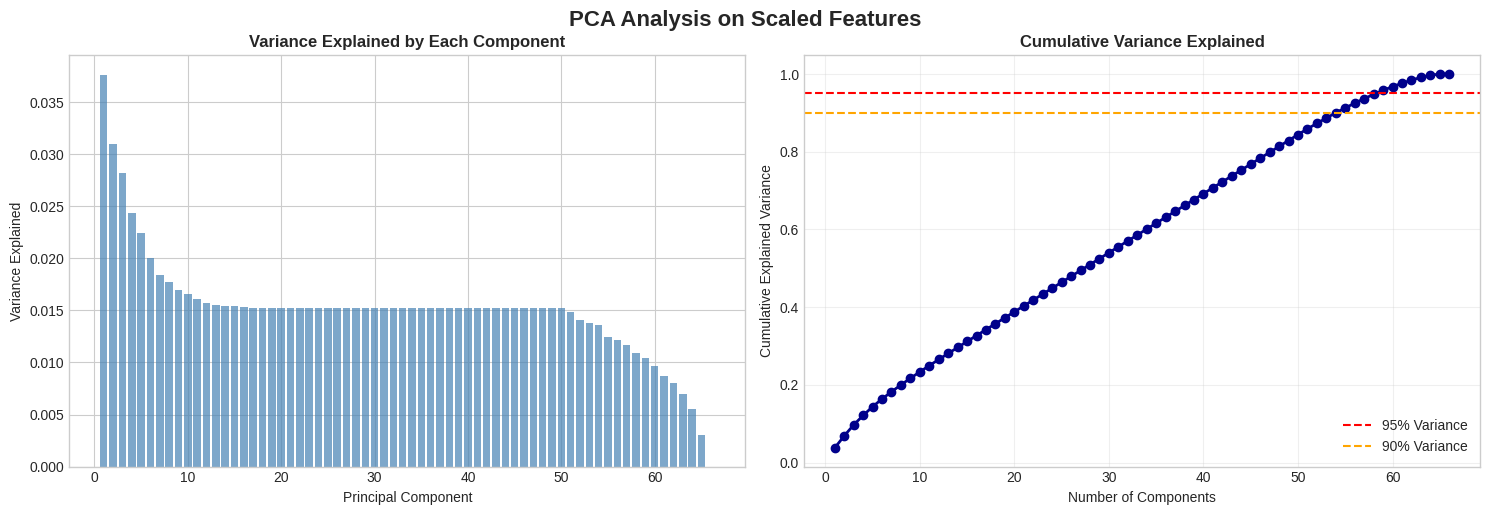

Number of components needed for 90% variance: 54
Number of components needed for 95% variance: 59
Total features: 66

Conclusion: PCA does not offer significant dimensionality reduction. Proceeding with all features.


In [ ]:
if not df.empty:
    pca_full = PCA()
    pca_full.fit(X_train_scaled)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].bar(range(1, len(pca_full.explained_variance_ratio_)+1),
                pca_full.explained_variance_ratio_, alpha=0.7, color='steelblue')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Variance Explained')
    axes[0].set_title('Variance Explained by Each Component', fontweight='bold')

    axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance,
                 marker='o', color='darkblue', linewidth=2)
    axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
    axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].set_title('Cumulative Variance Explained', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.suptitle('PCA Analysis on Scaled Features', y=1.02, fontsize=16, fontweight='bold')
    plt.show()

    n_90 = np.argmax(cumulative_variance >= 0.90) + 1
    n_95 = np.argmax(cumulative_variance >= 0.95) + 1
    print(f'Number of components needed for 90% variance: {n_90}')
    print(f'Number of components needed for 95% variance: {n_95}')
    print(f'Total features: {X_train_scaled.shape[1]}')
    print('\nConclusion: PCA does not offer significant dimensionality reduction. Proceeding with all features.')

## 8. Initial Model Evaluation (Default Parameters)

In [ ]:
if not df.empty:
    # Define a list of models to evaluate with their default settings.
    default_models = [
        ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)),
        ('CatBoost', CatBoostClassifier(random_state=42, verbose=0, thread_count=-1)),
        ('Extra Trees', ExtraTreesClassifier(random_state=42, n_jobs=-1)),
        ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1)),
        ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
        ('Decision Tree', DecisionTreeClassifier(random_state=42)),
        ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)),
        ('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
        ('AdaBoost', AdaBoostClassifier(random_state=42)),
        ('Gaussian Naive Bayes', GaussianNB()),
        ('K-Nearest Neighbors', KNeighborsClassifier(n_jobs=-1)),
        ('SGD Classifier', SGDClassifier(random_state=42, loss='log_loss', n_jobs=-1))
    ]

    initial_results = []

    print(' Evaluating Models with Default Parameters (using F1-Score)')
    for name, model in default_models:
        start_time = time.time()
        model.fit(X_train_scaled, y_train)
        train_time = time.time() - start_time

        y_pred = model.predict(X_test_scaled)
        f1_weighted = f1_score(y_test, y_pred, average='weighted')

        initial_results.append({
            'Model': name,
            'F1 Score (Weighted)': f1_weighted,
            'Train Time (s)': train_time
        })
        print(f"- {name:<28} | F1 (Weighted): {f1_weighted:.4f} | Time: {train_time:.2f} s")

    # Create a DataFrame to rank the initial results.
    initial_results_df = pd.DataFrame(initial_results)
    initial_results_df = initial_results_df.sort_values(by='F1 Score (Weighted)', ascending=False)

    print(' Initial Performance Ranking')
    display(initial_results_df)

    # Automatically select the top 5 models for the next tuning step.
    top_models_to_tune = initial_results_df.head(3)['Model'].tolist()
    print(f'Selected Top 3 Models for Tuning: {top_models_to_tune}')

 Evaluating Models with Default Parameters (using F1-Score)
- XGBoost                      | F1 (Weighted): 0.7246 | Time: 40.53 s
- CatBoost                     | F1 (Weighted): 0.7190 | Time: 49.91 s
- Extra Trees                  | F1 (Weighted): 0.7404 | Time: 4.69 s
- Random Forest                | F1 (Weighted): 0.6873 | Time: 7.21 s
- Gradient Boosting            | F1 (Weighted): 0.7010 | Time: 79.38 s
- Decision Tree                | F1 (Weighted): 0.6144 | Time: 1.32 s
- Logistic Regression          | F1 (Weighted): 0.6822 | Time: 2.65 s
- Linear Discriminant Analysis | F1 (Weighted): 0.6640 | Time: 0.32 s
- AdaBoost                     | F1 (Weighted): 0.5266 | Time: 2.47 s
- Gaussian Naive Bayes         | F1 (Weighted): 0.3938 | Time: 0.05 s
- K-Nearest Neighbors          | F1 (Weighted): 0.6502 | Time: 0.01 s
- SGD Classifier               | F1 (Weighted): 0.6641 | Time: 1.33 s
 Initial Performance Ranking


,Model,F1 Score (Weighted),Train Time (s)
2,Extra Trees,0.740428,4.689826
0,XGBoost,0.724575,40.530498
1,CatBoost,0.719017,49.907025
4,Gradient Boosting,0.700963,79.384139
3,Random Forest,0.687330,7.209877
6,Logistic Regression,0.682182,2.648261
11,SGD Classifier,0.664089,1.334362
7,Linear Discriminant Analysis,0.663967,0.317806
10,K-Nearest Neighbors,0.650157,0.010191
5,Decision Tree,0.614390,1.322284


Selected Top 3 Models for Tuning: ['Extra Trees', 'XGBoost', 'CatBoost']


## 9. Hyperparameter Tuning for Top Models (RandomizedSearchCV)

In [ ]:
if not df.empty and 'top_models_to_tune' in locals():
    # Define parameter distributions for our top models.
    # RandomizedSearchCV will sample from these to find good combinations efficiently.
    param_dist = {
        'XGBoost': {
            'n_estimators': randint(200, 600),
            'learning_rate': uniform(0.01, 0.2),
            'max_depth': randint(5, 15),
            'subsample': uniform(0.6, 0.4), # [0.6, 1.0]
            'colsample_bytree': uniform(0.6, 0.4) # [0.6, 1.0]
        },
        'CatBoost': {
            'iterations': randint(200, 600),
            'learning_rate': uniform(0.01, 0.2),
            'depth': randint(5, 12),
            'l2_leaf_reg': uniform(1, 9) # [1, 10]
        },
        'Extra Trees': {
            'n_estimators': randint(200, 800),
            'max_depth': randint(10, 40),
            'min_samples_split': randint(2, 11),
            'min_samples_leaf': randint(1, 6),
            'max_features': ['sqrt', 'log2', None]
        }
    }

    # Create a scorer to ensure RandomizedSearch optimizes for weighted F1-score.
    f1_scorer = make_scorer(f1_score, average='weighted')

    hpt_results = []
    tuned_best_estimators = {}

    print(f' Hyperparameter Tuning for Top Models ')

    for name in top_models_to_tune:
        if name in param_dist:
            print(f'\nTuning {name}...')
            start_time = time.time()

            # Set up RandomizedSearchCV
            model = [m[1] for m in default_models if m[0] == name][0] # Get the model instance
            random_search = RandomizedSearchCV(
                estimator=model,
                param_distributions=param_dist[name],
                n_iter=10, # Number of parameter combinations to try
                scoring=f1_scorer,
                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                verbose=1,
                random_state=42,
                n_jobs=-1
            )

            random_search.fit(X_train_scaled, y_train)
            end_time = time.time()

            # Store the best estimator found
            tuned_best_estimators[name] = random_search.best_estimator_

            # Store results for comparison
            hpt_results.append({
                'Model': name,
                'Best CV F1 Score': random_search.best_score_,
                'Tuning Time (s)': end_time - start_time,
                'Best Params': random_search.best_params_
            })
            print(f" {name} tuning complete. Best CV F1: {random_search.best_score_:.4f}")

    # Display tuning results
    tuned_df = pd.DataFrame(hpt_results).sort_values(by='Best CV F1 Score', ascending=False)
    print(' Hyperparameter Tuning Results ')
    display(tuned_df[['Model', 'Best CV F1 Score', 'Tuning Time (s)']])

 Hyperparameter Tuning for Top Models 

Tuning Extra Trees...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 Extra Trees tuning complete. Best CV F1: 0.8695

Tuning XGBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 XGBoost tuning complete. Best CV F1: 0.8817

Tuning CatBoost...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
 CatBoost tuning complete. Best CV F1: 0.8798
 Hyperparameter Tuning Results 


,Model,Best CV F1 Score,Tuning Time (s)
1,XGBoost,0.881744,1345.586579
2,CatBoost,0.879784,3810.779838
0,Extra Trees,0.869456,1100.844042


## 10. Neural Network

In [ ]:
if not df.empty:
    #  1. Prepare Data
    # One-hot encode the target variable for use with categorical_crossentropy loss.
    y_train_nn = to_categorical(y_train, num_classes=len(le.classes_))
    y_test_nn = to_categorical(y_test, num_classes=len(le.classes_))
    N_features = X_train_scaled.shape[1]
    N_classes = y_train_nn.shape[1]
    print(f'✓ NN data prepared: Input shape ({N_features}), Output classes ({N_classes})')

    #  2. Define a Flexible Model Creation Function
    def create_nn_model(architecture, activation='relu', dropout_rate=0.3, optimizer_config={'type': 'adam', 'lr': 0.001}):
        model = Sequential()
        model.add(Dense(architecture[0], activation=activation, input_shape=(N_features,)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

        for neurons in architecture[1:]:
            model.add(Dense(neurons, activation=activation))
            model.add(BatchNormalization())
            model.add(Dropout(dropout_rate))

        model.add(Dense(N_classes, activation='softmax'))

        if optimizer_config['type'] == 'adam': optimizer = Adam(learning_rate=optimizer_config['lr'])
        elif optimizer_config['type'] == 'rmsprop': optimizer = RMSprop(learning_rate=optimizer_config['lr'])
        else: optimizer = SGD(learning_rate=optimizer_config['lr'], momentum=0.9)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    #  3. Define NN Configurations to Test

    nn_configs = {
        # Renamed 'optimizer' key to 'optimizer_config' to match function definition
        'NN_Baseline_Relu': {'architecture': [256, 128], 'activation': 'relu', 'optimizer_config': {'type': 'adam', 'lr': 0.001}},
        'NN_Deeper_Relu': {'architecture': [256, 128, 64], 'activation': 'relu', 'optimizer_config': {'type': 'adam', 'lr': 0.001}},
        'NN_Wider_Relu': {'architecture': [512, 256, 128], 'activation': 'relu', 'optimizer_config': {'type': 'adam', 'lr': 0.0005}},
        'NN_ELU_RMSprop': {'architecture': [256, 128, 64], 'activation': 'elu', 'optimizer_config': {'type': 'rmsprop', 'lr': 0.001}},
    }

    nn_results = {}
    nn_models_trained = {}

    # Define callbacks for efficient training.
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)

    #  4. Train and Evaluate Each NN Configuration
    print(f' Training {len(nn_configs)} Neural Network')
    for name, config in nn_configs.items():
        print(f'\nTraining: {name}...')
        model = create_nn_model(**config)

        history = model.fit(X_train_scaled, y_train_nn, epochs=100, batch_size=64,
                            validation_split=0.2, callbacks=[early_stop, reduce_lr], verbose=0)

        y_pred_prob = model.predict(X_test_scaled, verbose=0)
        y_pred_nn = np.argmax(y_pred_prob, axis=1)
        f1_nn = f1_score(y_test, y_pred_nn, average='weighted')

        nn_results[name] = {'Model': name, 'F1 Score': f1_nn, 'predictions': y_pred_nn, 'probabilities': y_pred_prob}
        nn_models_trained[name] = model
        print(f"✓ {name} completed. Test F1: {f1_nn:.4f}")

    # Find and store the best NN model.
    best_nn_name = max(nn_results, key=lambda name: nn_results[name]['F1 Score'])
    tuned_best_estimators[best_nn_name] = nn_models_trained[best_nn_name]
    print(f" Best NN Config: {best_nn_name} (F1 Score: {nn_results[best_nn_name]['F1 Score']:.4f})")

✓ NN data prepared: Input shape (66), Output classes (6)
 Training 4 Neural Network

Training: NN_Baseline_Relu...
✓ NN_Baseline_Relu completed. Test F1: 0.6943

Training: NN_Deeper_Relu...
✓ NN_Deeper_Relu completed. Test F1: 0.6934

Training: NN_Wider_Relu...
✓ NN_Wider_Relu completed. Test F1: 0.6973

Training: NN_ELU_RMSprop...
✓ NN_ELU_RMSprop completed. Test F1: 0.6944
 Best NN Config: NN_Wider_Relu (F1 Score: 0.6973)


## 11. Final Model Comparison and Evaluation

In [ ]:
if not df.empty and 'tuned_best_estimators' in locals():
    final_results = []

    # Evaluate all tuned models (including the best NN) on the test set.
    print('Final Evaluation of Best Models on Test Set')
    for name, model in tuned_best_estimators.items():
        # Retrieve predictions and probabilities.
        if 'NN' in name:
            y_pred = nn_results[name]['predictions']
            y_proba = nn_results[name]['probabilities']
        else:
            y_pred = model.predict(X_test_scaled)
            y_proba = model.predict_proba(X_test_scaled)

        # Calculate key metrics.
        final_results.append({
            'Model': name,
            'Test Accuracy': accuracy_score(y_test, y_pred),
            'Test F1 Score': f1_score(y_test, y_pred, average='weighted'),
            'Log Loss': log_loss(y_test, y_proba),
            'Predictions': y_pred, # Store for later use
            'Probabilities': y_proba # Store for ROC curve
        })

    # Create and display the final comparison table.
    final_results_df = pd.DataFrame(final_results).sort_values(by='Test F1 Score', ascending=False)
    display(final_results_df[['Model', 'Test Accuracy', 'Test F1 Score', 'Log Loss']])

Final Evaluation of Best Models on Test Set


,Model,Test Accuracy,Test F1 Score,Log Loss
1,XGBoost,0.722575,0.726475,0.855559
2,CatBoost,0.707055,0.711556,0.833748
3,NN_Wider_Relu,0.690300,0.697332,1.073499
0,Extra Trees,0.685891,0.690840,0.877377


## 12. Confusion Matrices for Top Models



Confusion Matrices (Top Performing Models)


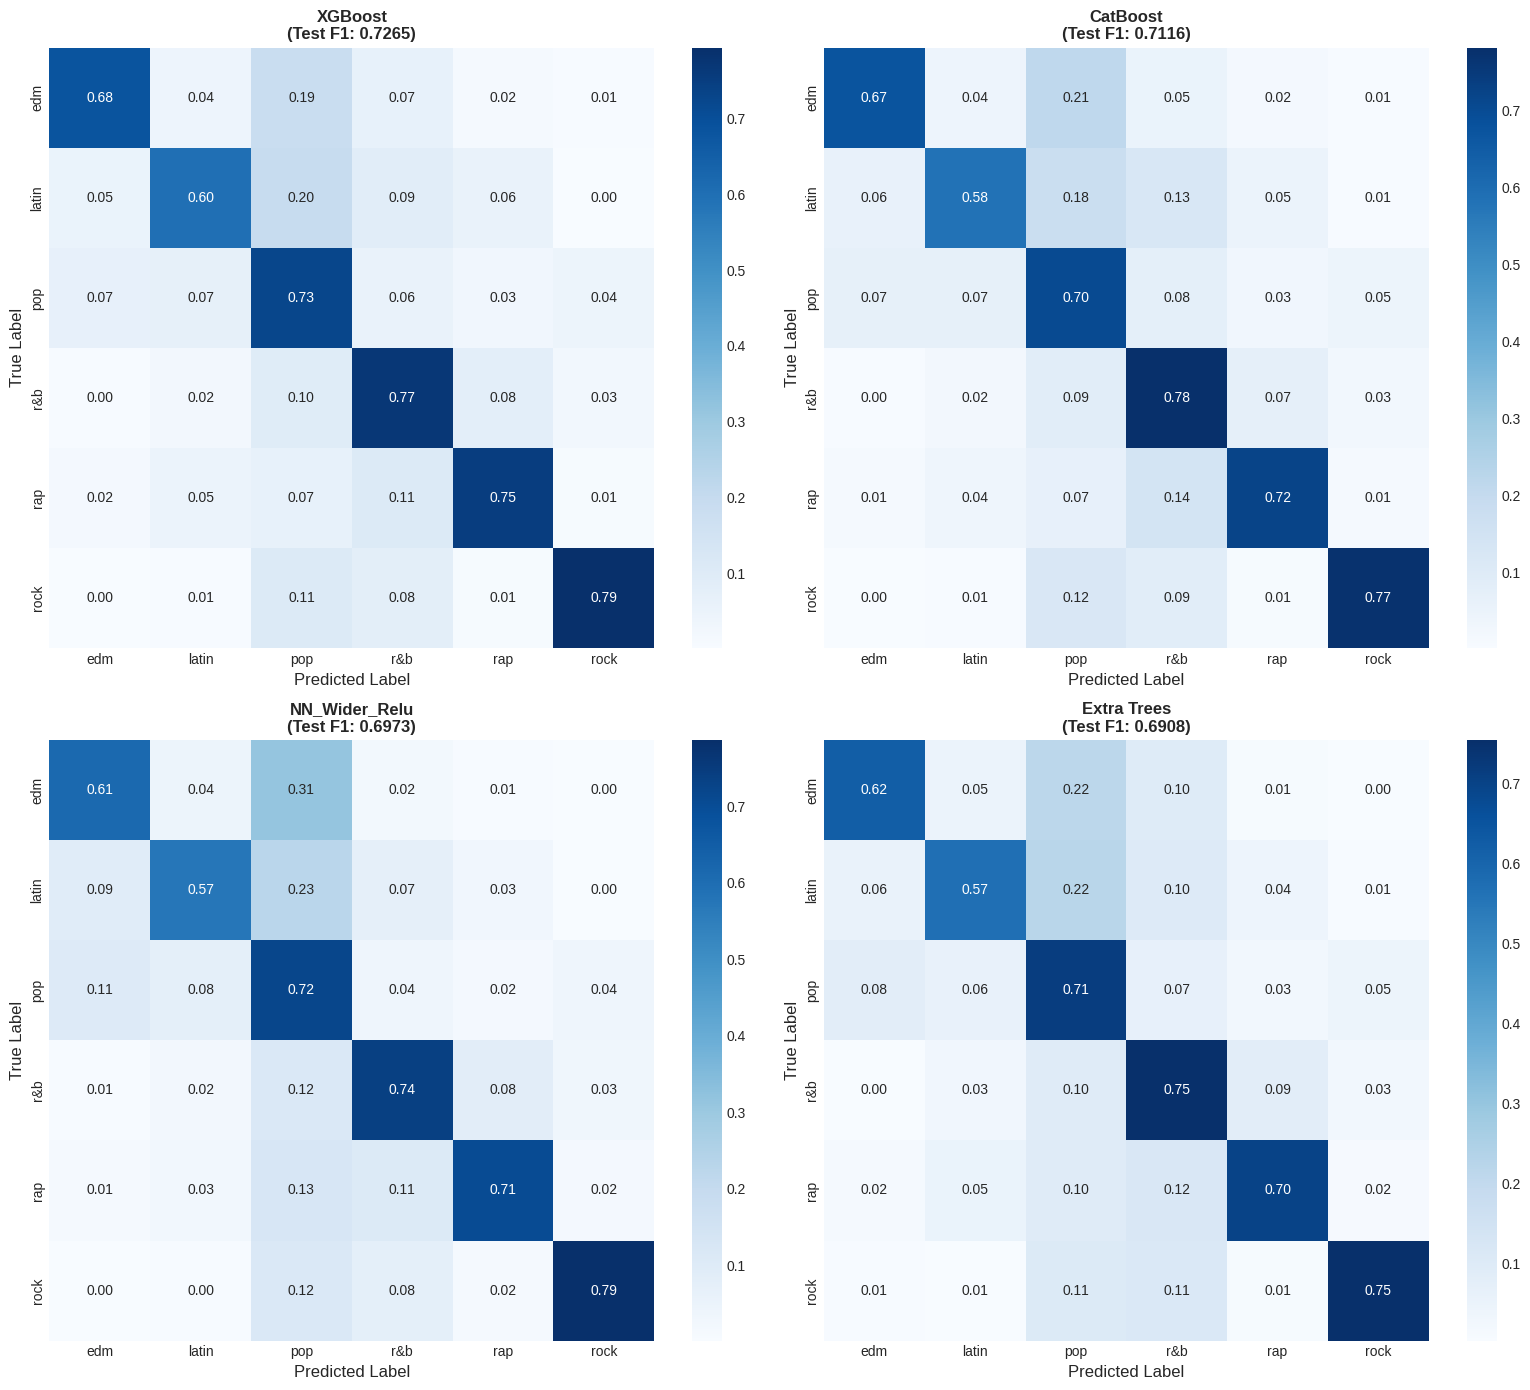

In [ ]:
if not df.empty and 'final_results_df' in locals():
    # Get the names of the top 4 performing models from our final results.
    top_final_models = final_results_df.head(4)['Model'].tolist()

    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.ravel()

    print('\nConfusion Matrices (Top Performing Models)')
    for idx, model_name in enumerate(top_final_models):
        # Find the stored predictions for the current model.
        model_result = final_results_df[final_results_df['Model'] == model_name].iloc[0]
        y_pred = model_result['Predictions']

        # Create and normalize the confusion matrix.
        cm = confusion_matrix(y_test, y_pred)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Plot the heatmap.
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=axes[idx],
                    xticklabels=le.classes_, yticklabels=le.classes_, annot_kws={"size": 10})
        axes[idx].set_title(f'{model_name}\n(Test F1: {model_result["Test F1 Score"]:.4f})', fontweight='bold')
        axes[idx].set_xlabel('Predicted Label', fontsize=12)
        axes[idx].set_ylabel('True Label', fontsize=12)

    plt.tight_layout()
    plt.show()

## 13. ROC Curves for Top Models


--- ROC Curve Analysis (Top Performing Models) ---


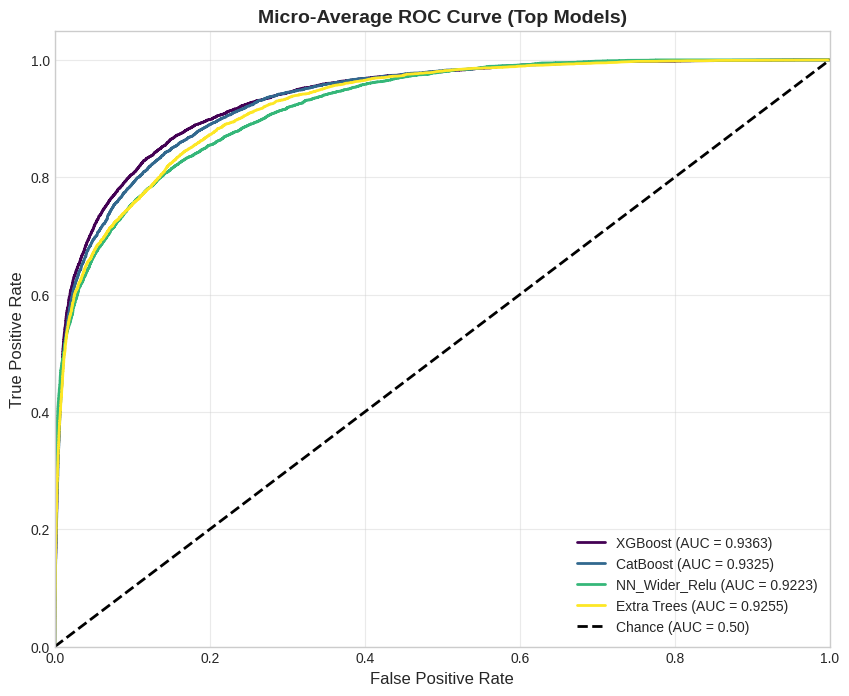

In [ ]:
if not df.empty and 'final_results_df' in locals():
    print('\n--- ROC Curve Analysis (Top Performing Models) ---')
    # Binarize the true labels for multi-class ROC analysis.
    y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))

    plt.figure(figsize=(10, 8))
    model_colors = plt.cm.viridis(np.linspace(0, 1, len(top_final_models)))

    for idx, model_name in enumerate(top_final_models):
        # Retrieve the stored probabilities.
        model_result = final_results_df[final_results_df['Model'] == model_name].iloc[0]
        y_proba = model_result['Probabilities']

        # Calculate the micro-average ROC curve and AUC.
        # Micro-averaging aggregates the contributions of all classes to compute the average metric.
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, color=model_colors[idx], lw=2,
                 label=f'{model_name} (AUC = {roc_auc:.4f})')

    # Plot the diagonal 'chance' line.
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (AUC = 0.50)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Micro-Average ROC Curve (Top Models)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.4)
    plt.show()

In [ ]:
# Calculate and Display Log Loss for Top Models

if not df.empty and 'final_results_df' in locals() and 'tuned_best_estimators' in locals():
    print(' Log Loss Calculation (Top Performing Models)')

    # Get the names of the top models (e.g., top 4) from the final evaluation
    top_final_models_logloss = final_results_df.head(4)['Model'].tolist()

    log_loss_results = {}

    for model_name in top_final_models_logloss:
        model = tuned_best_estimators[model_name] # Get the trained model instance

        # Get probability predictions
        y_score = None # Initialize y_score
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test_scaled)
        elif 'NN' in model_name and model_name in nn_results: # Check if it's an NN and results exist
             # Retrieve stored probabilities for the best NN
            y_score = nn_results[model_name]['probabilities']
        else:
            print(f"Warning: Model {model_name} cannot produce probabilities. Skipping Log Loss.")
            log_loss_results[model_name] = np.nan # Assign NaN if probabilities aren't available
            continue

        # Calculate Log Loss
        try:
            # Use the true labels (y_test) and predicted probabilities (y_score)
            current_log_loss = log_loss(y_test, y_score)
            log_loss_results[model_name] = current_log_loss
            print(f"Calculating Log Loss for: {model_name}")
        except ValueError as e:
            print(f"Could not calculate Log Loss for {model_name}: {e}")
            log_loss_results[model_name] = np.nan
        except NameError:
             print(f"Error: Required variables (like y_test or y_score) not defined for {model_name}")
             log_loss_results[model_name] = np.nan


    # Print the Log Loss results, sorted from best (lowest) to worst
    print(" Log Loss Results (Lower is Better)")
    if log_loss_results: # Check if dictionary is not empty
        # Sort the dictionary by value (log loss score)
        log_loss_sorted = sorted(log_loss_results.items(), key=lambda item: item[1])
        for name, ll in log_loss_sorted:
            print(f"{name}: {ll:.4f}")
    else:
        print("No Log Loss results to display.")

else:
     print("Prerequisites not met: Data not loaded or models not evaluated. Skipping Log Loss calculation.")

 Log Loss Calculation (Top Performing Models)
Calculating Log Loss for: XGBoost
Calculating Log Loss for: CatBoost
Calculating Log Loss for: NN_Wider_Relu
Calculating Log Loss for: Extra Trees
 Log Loss Results (Lower is Better)
CatBoost: 0.8337
XGBoost: 0.8556
Extra Trees: 0.8774
NN_Wider_Relu: 1.0735
